# Experiment 1: All metrics / Default parameters / TSB

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_tsb')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 7


In [4]:
formal_names = {
    'FF-VUS-PR': 'FF-VUS (L: 128)',
    'FF-VUS-PR-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC-PR': 'AUC',
    'VUS-PR': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC-PR': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#99cae4',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'RF': '#a6d2c3',                    # Useless competitors
    'AFFILIATION': '#95bdaf',        # Useless competitors
    'Range-AUC (L: 128)': '#84a89c',       # Useless competitors
}

In [59]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0)

    anom_time_col = [x for x in curr_df.columns if 'oordinates' in x.lower()]
    if len(anom_time_col) > 0:
        curr_df = curr_df.rename({anom_time_col[0]: 'Anomaly coordinates time'}, axis=1)
    
    df = pd.concat([df, curr_df], ignore_index=True)
    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 136.34it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
7534,KDD21/213_UCR_Anomaly_STAFFIIIDatabase_33211_1...,299999,1,450.0,128.0,FF-VUS-GPU (L: 128),0.047388,0.002831,1.0,True,...,0.000391,0.000351,0.000112,0.000034,0.000077,0.000213,0.000187,0.000397,0.000111,0.000043
370,OPPORTUNITY/S1-ADL4.test.csv@79.out,32698,2,500.0,128.0,Range-AUC (L: 128),0.019759,0.041925,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9914,OPPORTUNITY/S2-ADL4.test.csv@38.out,32542,2,370.0,NaN,RF,0.013848,0.313801,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

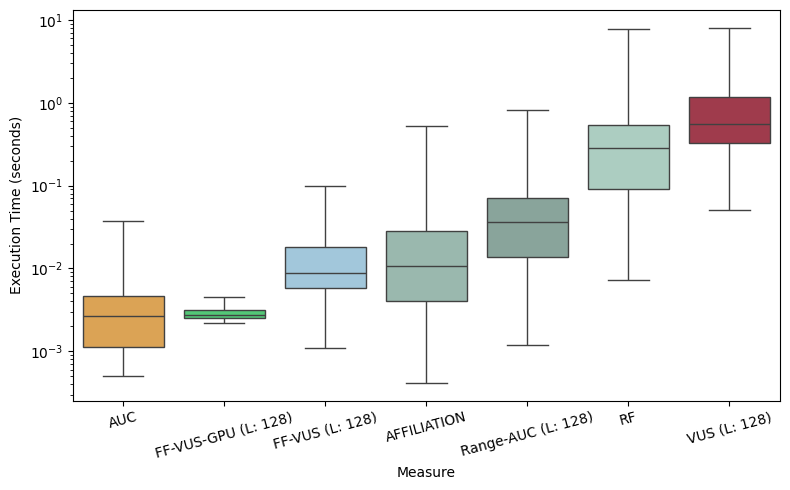

In [115]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    # saturation=1,
)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

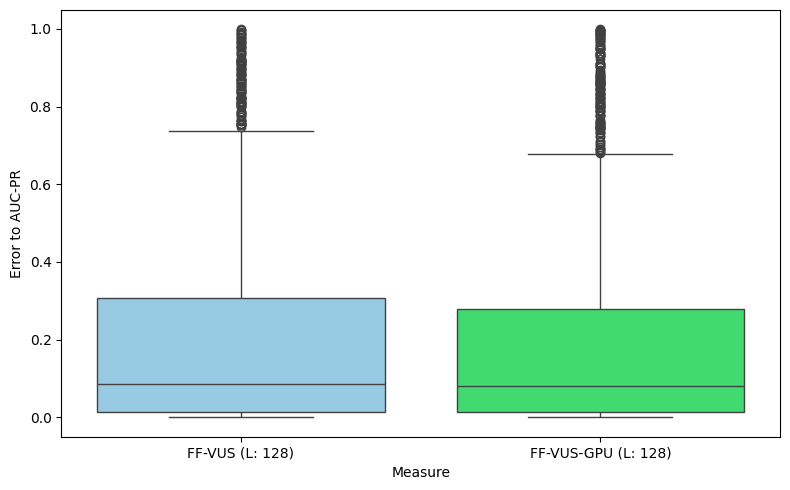

In [62]:
# What is the error between the difference metrics
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')
plt.figure(figsize=(8, 5))

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1)

sns.boxplot(dif_df.abs(), showfliers=True, palette=color_palette, saturation=1)
plt.xlabel('Measure')
plt.ylabel('Error to AUC-PR')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'error_to_aucpr.svg'))
plt.show()

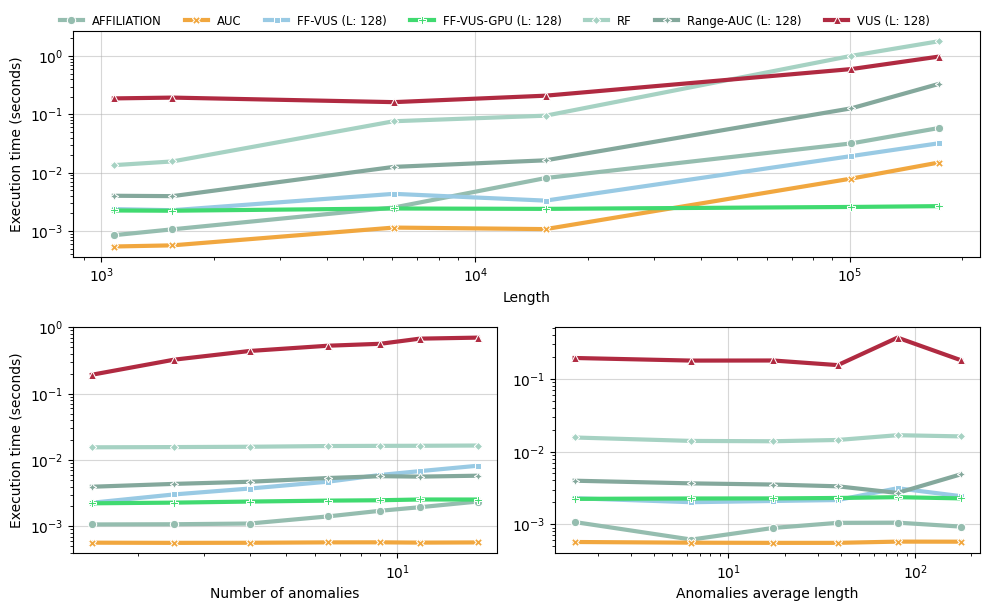

In [63]:
bins = 20
attr_control = {}
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    df[f'{attr} bin'] = pd.qcut(df[attr], q=bins, duplicates='drop')
    attr_control[attr] = df[f'{attr} bin'].value_counts().idxmax()

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4)
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])

    mask = pd.Series(True, index=df.index)
    for attr in attributes:
        if attr != attribute:
            mask &= (df[f'{attr} bin'] == attr_control[attr])
    curr_df = df[mask]
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )
  
    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center',
        y='Metric time',
        hue='Metric',
        data=grouped,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=3,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis

handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

## Time analysis

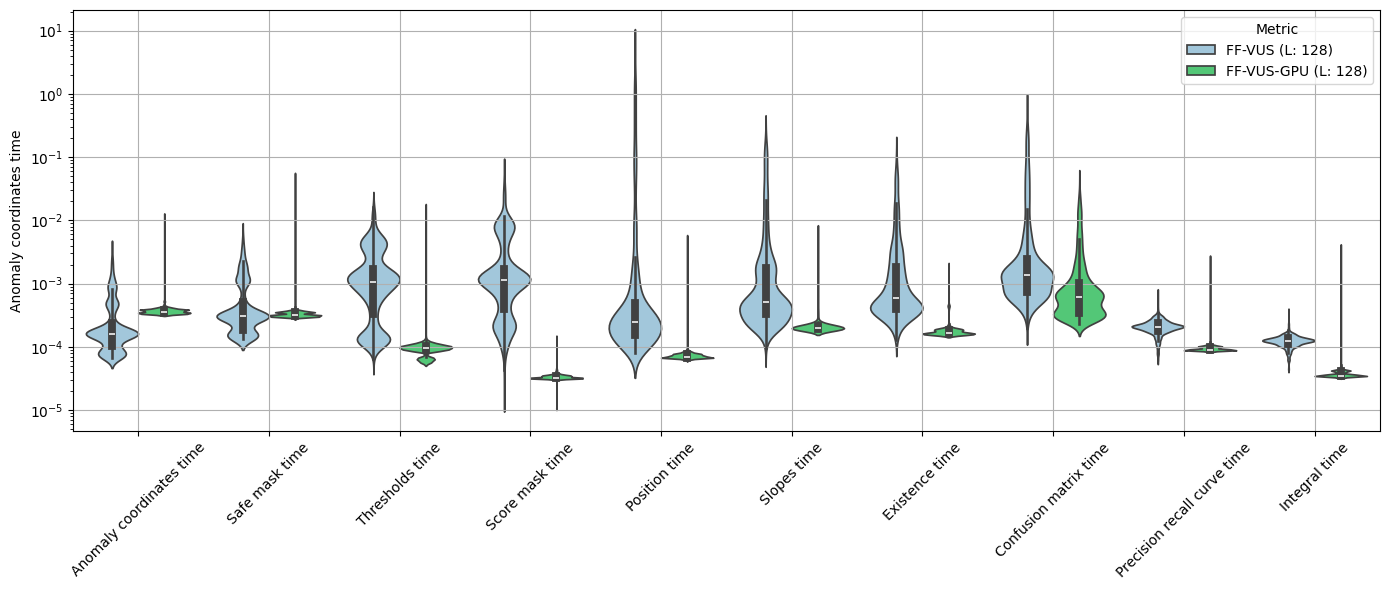

In [99]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, ax = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

curr_df = df[df['Metric'].isin(metrics)]
for i, col in enumerate(time_analysis_cols):
    sns.violinplot(curr_df, x=i, y=col, log_scale=True, hue='Metric', legend=(i == 0), palette=color_palette)
ax.set_xticks(np.arange(len(time_analysis_cols)), time_analysis_cols)
ax.tick_params(axis='x', rotation=45)
ax.grid()

plt.tight_layout()
plt.show()

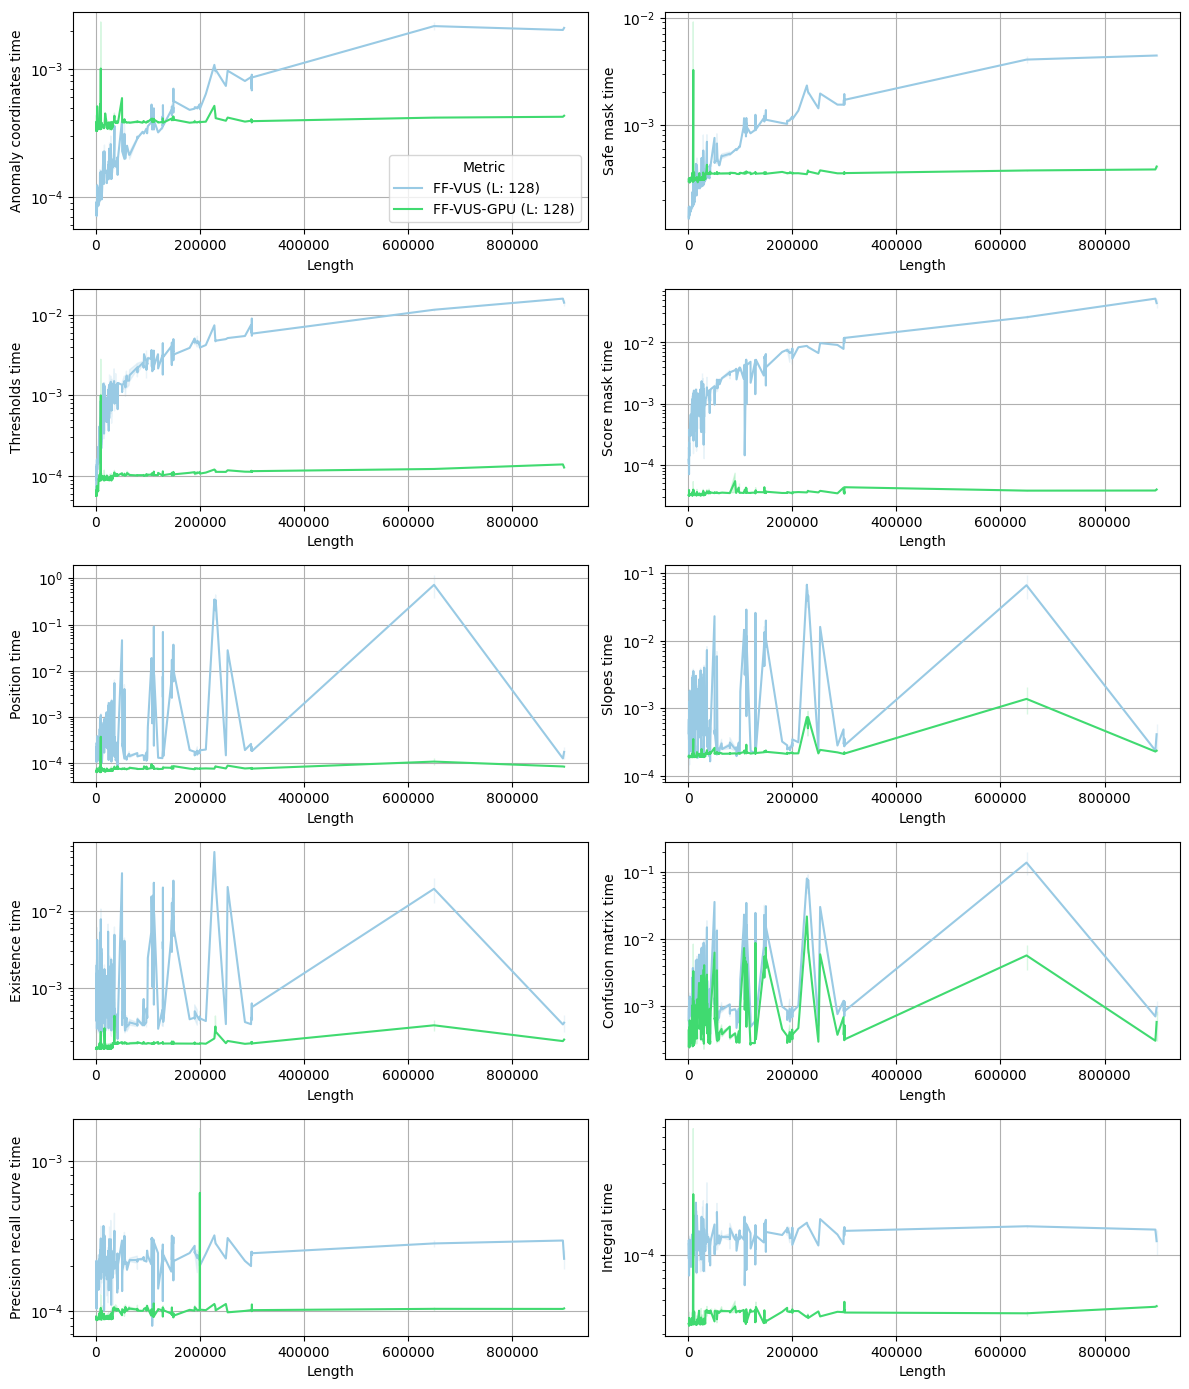

In [114]:
fig, ax = plt.subplots(5, 2, figsize=(12, 14))

for col, axis in zip(time_analysis_cols, ax.flatten()):
    sns.lineplot(
        curr_df, 
        x='Length', 
        y=col, 
        hue='Metric', 
        ax=axis, 
        legend=(col == 'Anomaly coordinates time'), 
        palette=color_palette
    )
    axis.set_yscale('log')
    axis.grid()
plt.tight_layout()
plt.show()

## Random stuff

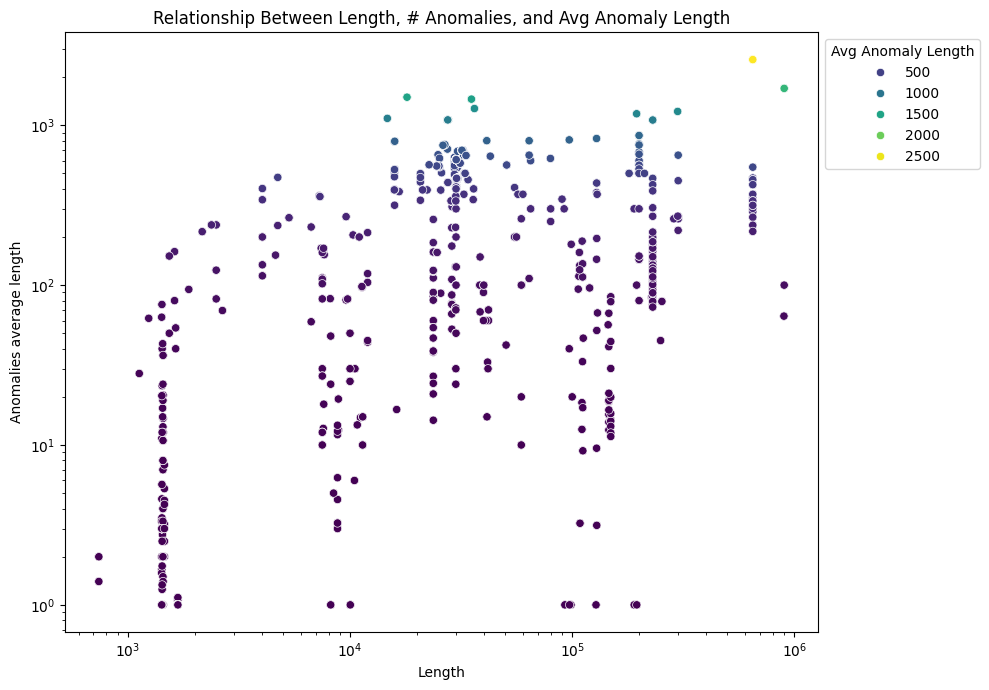

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(
    data=df,
    x='Length',
    y='Anomalies average length',
    # size='Anomalies average length',
    hue='Anomalies average length',
    palette='viridis',
    sizes=(20, 300),
    ax=ax
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Relationship Between Length, # Anomalies, and Avg Anomaly Length")
ax.legend(title='Avg Anomaly Length', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [10]:
df['Dataset'] = df.apply(lambda row: row['Time series'].split('/')[0] , axis=1)
df.sample(3)

,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Step,Global mask,...,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Anomalies coordinates time,Length bin,Number of anomalies bin,Anomalies average length bin,Dataset
2900,YAHOO/YahooA4Benchmark-TS85_data.out,1679,16,1.0,128.0,FF-VUS (L: 128),0.813517,0.009972,1.0,True,...,0.0022,0.004471,0.001648,0.000225,0.000125,NaN,"(1420.0, 1679.0]","(13.0, 20.0]","(0.999, 2.0]",YAHOO
9217,KDD21/247_UCR_Anomaly_tilt12755mtable_50211_12...,199999,1,80.0,NaN,AFFILIATION,0.489375,0.052489,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(146254.0, 200000.0]","(0.999, 2.0]","(76.069, 84.716]",KDD21
11240,KDD21/082_UCR_Anomaly_DISTORTEDresperation4_70...,195249,1,1.0,NaN,RF,0.000000,1.819989,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(146254.0, 200000.0]","(0.999, 2.0]","(0.999, 2.0]",KDD21
